
# Logistic Regressions
------------

## Part A, we would like to use an example to show how the sparse-constrained optimization for logistic regression works in our program.

### Introduction

Logistic regression is an important model to solve classification problem, which is expressed specifically as:
$$
\begin{aligned}
& P(y=1 \mid x)=\frac{1}{1+\exp \left(-x^T \beta\right)}, \\
& P(y=0 \mid x)=\frac{1}{1+\exp \left(x^T \beta\right)},
\end{aligned}
$$
where $\beta$ is an unknown parameter vector that to be estimated. Since we expect only a few explanatory variables contributing to predicting $y$, we assume $\beta$ is sparse vector with sparsity level $s$.

With $n$ independent data of the explanatory variables $x$ and the response variable $y$, we can estimate $\beta$ by minimizing the negative log-likelihood function under sparsity constraint:

<a id='loss'></a>
$$
\arg \min _{\beta \in R^p} L(\beta):=-\frac{1}{n} \sum_{i=1}^n\left\{y_i x_i^T \beta-\log \left(1+\exp \left(x_i^T \beta\right)\right)\right\}, \text { s.t. }\|\beta\|_0 \leq s \tag{1}
$$ 

### Import necessary packages

In [14]:
import jax.numpy as jnp
import numpy as np
from skscope import ScopeSolver
import numpy as np

### Set a seed

In [3]:
np.random.seed(123)

### Generate the data

Firstly, we define a data generator function to provide a way to generate suitable dataset for this task.

In [16]:
def data_generator(n, p, k, seed):
    coef = np.zeros(p)
    np.random.seed(seed)
    coef[np.random.choice(np.arange(p), k, replace=False)] = np.random.choice([1, -1], k) * 100
    # generate correlation matrix with exponential decay
    R = np.zeros((p, p))
    for i in range(p):
        for j in range(i, p):
            R[i, j] = 0.2 ** abs(i - j)
    R = R + R.T - np.identity(p)

    x = np.random.multivariate_normal(mean=np.zeros(p), cov=R, size=(n,))

    xbeta = np.matmul(x, coef)
    xbeta[xbeta > 30] = 30
    xbeta[xbeta < -30] = -30

    p = np.exp(xbeta) / (1 + np.exp(xbeta))
    y = np.random.binomial(1, p)

    return coef, (x, y)

We then use this function to generate a data set containg 500 observations and set only 5 of the 500 variables to have effect on the expectation of the response.

In [17]:
n, p, s, rho = 500, 500, 5, 0.0
X, y, true_params, true_support_set = make_logistic_data(n, p, s, rho , 0)

### Define function to calculate negative log-likelihood of logistic regression

Secondly, we define the loss function `logistic_loss` accorting to [1](#loss) that matches the data generating function `make_logistic_data`.

In [18]:
def logistic_loss(params):
    xbeta = jnp.clip(X @ params, -30, 30)
    return jnp.sum(jnp.log(1 + jnp.exp(xbeta)) - y * xbeta)

### Use SIC to decide the optimal support size

There are four types of information criterion can be implemented in `skscope.utilities`:
- Akaike information criterion (AIC)
- Bayesian information criterion (BIC)
- Extend BIC (EBIC)
- Special information criterion (SIC)
  
You can just need one line of code to call any IC, here we use SIC:

In [19]:
from skscope.utilities import SIC

In [20]:
solver = ScopeSolver(p, sparsity = range(1,10), sample_size = n, ic_method = SIC)
params = solver.solve(logistic_loss, jit=True)

In [8]:
print(solver.params[solver.get_support()])

[1.2883844  1.25061865 1.80887014 1.11882953 1.4487943 ]


We can further compare the coefficients estimated by `skscope` and the real coefficients in three-fold:

* The true support set and the estimated support set

* The true nonzero parameters and the estimated nonzero parameters

* The true loss value and the estimated values

In [22]:
print("True support set: ", (true_params.nonzero()))
print("Estimated support set: ", (solver.support_set))

True support set:  (array([ 90,  97, 340, 395, 477]),)
Estimated support set:  [ 90  97 340 395 477]


In [23]:
print("True parameters: ", true_params[true_params.nonzero()])
print("Estimated parameters: ", solver.params[solver.support_set])

True parameters:  [ 100. -100.  100. -100. -100.]
Estimated parameters:  [ 4398.05269919 -4284.12650116  4302.04134409 -4283.66682006
 -4274.74040784]


In [24]:
print("True loss value: ", logistic_loss(true_params))
print("Estimated loss value: ", logistic_loss(solver.params))

True loss value:  3.9117422
Estimated loss value:  1.4066623e-05


### More on the results

We can plot the sparse signal recovering from the noisy observations to visualize the results.

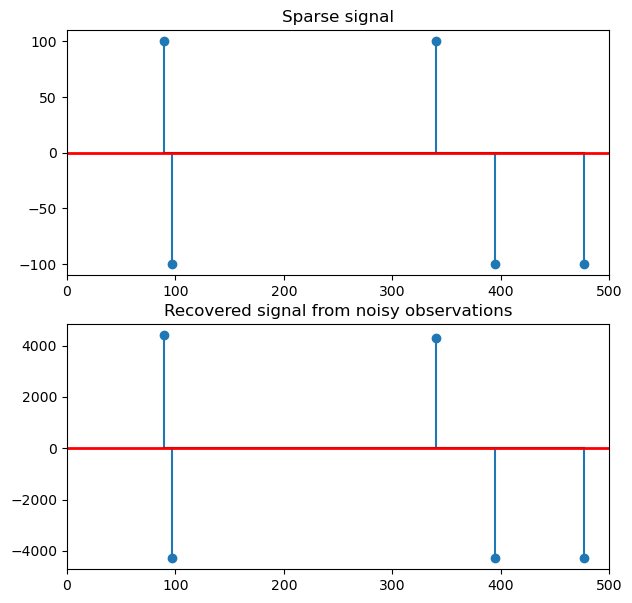

In [25]:
import matplotlib.pyplot as plt
(inx_true,) =  true_params.nonzero()
(inx_est,) =  solver.params.nonzero()

# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
plt.stem(inx_true, true_params[inx_true], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Sparse signal")
#plt.plot(inx_true, true_params[inx_true], drawstyle='steps-post')

# plot the noisy reconstruction
plt.subplot(2, 1, 2)
plt.stem(inx_est, solver.params[inx_est], markerfmt='o', basefmt='k-')
plt.plot([0, 500], [0, 0], 'r-', lw=2)
plt.xlim(0, 500)
plt.title("Recovered signal from noisy observations")
#plt.plot(inx_est, solver.params[inx_est], drawstyle='steps-post')

plt.show()

## Part B, we will use cross-validation to select the optimal support set and compare its runtime with that of SIC.

#### Use SICto decide the optimal support size and Record the runtime of SIC.

In [26]:
import time
# Record start time
start_time = time.time()

solver_ic = ScopeSolver(p, sparsity = range(1, 10), sample_size = n, ic_method = SIC)
params_ic = solver_ic.solve(logistic_loss, jit=True)

# Variable selection accuracy
print("True support set: ", (true_params.nonzero()))
print("skscope estimated support set: ", (solver_ic.support_set))

# Calculate runtime
runtime = time.time() - start_time
print("Runtime of SIC:", runtime, "seconds")

True support set:  (array([ 90,  97, 340, 395, 477]),)
skscope estimated support set:  [ 90  97 340 395 477]
Runtime of SIC: 0.4018411636352539 seconds


#### Use CV to decide the optimal support size and record the runtime of CV.

In [27]:
def logistic_loss_cv(params, data):
    xbeta = jnp.clip(data[0] @ params, -30, 30)
    return jnp.sum(jnp.log(1 + jnp.exp(xbeta)) - data[1] * xbeta)

# Record start time
start_time = time.time()

solver_cv = ScopeSolver(p, sparsity = range(1, 10), sample_size = n, cv = 5,
                        split_method=lambda data, index: (data[0][index, :], data[1][index]))
params_cv = solver_cv.solve(logistic_loss_cv, jit=True, data=(X, y))

# Variable selection accuracy
print("True support set: ", (true_params.nonzero()))
print("skscope estimated support set: ", (solver_cv.support_set))

# Calculate runtime
runtime = time.time() - start_time
print("Runtime of CV:", runtime, "seconds")

True support set:  (array([ 90,  97, 340, 395, 477]),)
skscope estimated support set:  [ 90  97 340 395 477]
Runtime of CV: 3.7037763595581055 seconds


Comparing the results of SIC and CV criteria, we find that while maintaining high accuracy in variable selection, SIC exhibits a clear time advantage.

## Part C, we compare the results under two different circumstances: using warmstart and not using warmstart.

#### Using warmstart 

In [28]:
# Record start time
start_time = time.time()

solver_ws = ScopeSolver(p, s)
params_ws = solver_ws.solve(logistic_loss, jit=True)

# Calculate runtime
runtime = time.time() - start_time
print("Runtime:", runtime, "seconds")

Runtime: 0.24225878715515137 seconds


In [30]:
print("True support set: ", (true_params.nonzero()))
print("Estimated support set: ", (solver_ws.support_set))

True support set:  (array([ 90,  97, 340, 395, 477]),)
Estimated support set:  [ 90  97 340 395 477]


#### Not using warmstart

In [31]:
# Record start time
start_time = time.time()

solver_nws = ScopeSolver(p, s)
solver_nws.warm_start = False
params_nws = solver_nws.solve(logistic_loss, jit=True)

# Calculate runtime
runtime = time.time() - start_time
print("Runtime:", runtime, "seconds")

Runtime: 0.37964749336242676 seconds


In [33]:
print("True support set: ", (true_params.nonzero()))
print("Estimated support set: ", (solver_nws.support_set))

True support set:  (array([ 90,  97, 340, 395, 477]),)
Estimated support set:  [ 90  97 340 395 477]


Hint: all solvers default to using warmstart, which can slightly prolong computation time if not utilized